# PS reconstruction, non-Gaussian beam

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_awa_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [5]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir =  os.path.join('data', 'non_gaussian_beam', 'normal')

p0c = 43.36e6 # reference momentum in eV/c
gt_beam = torch.load("data/nonlinear_beam.pt")

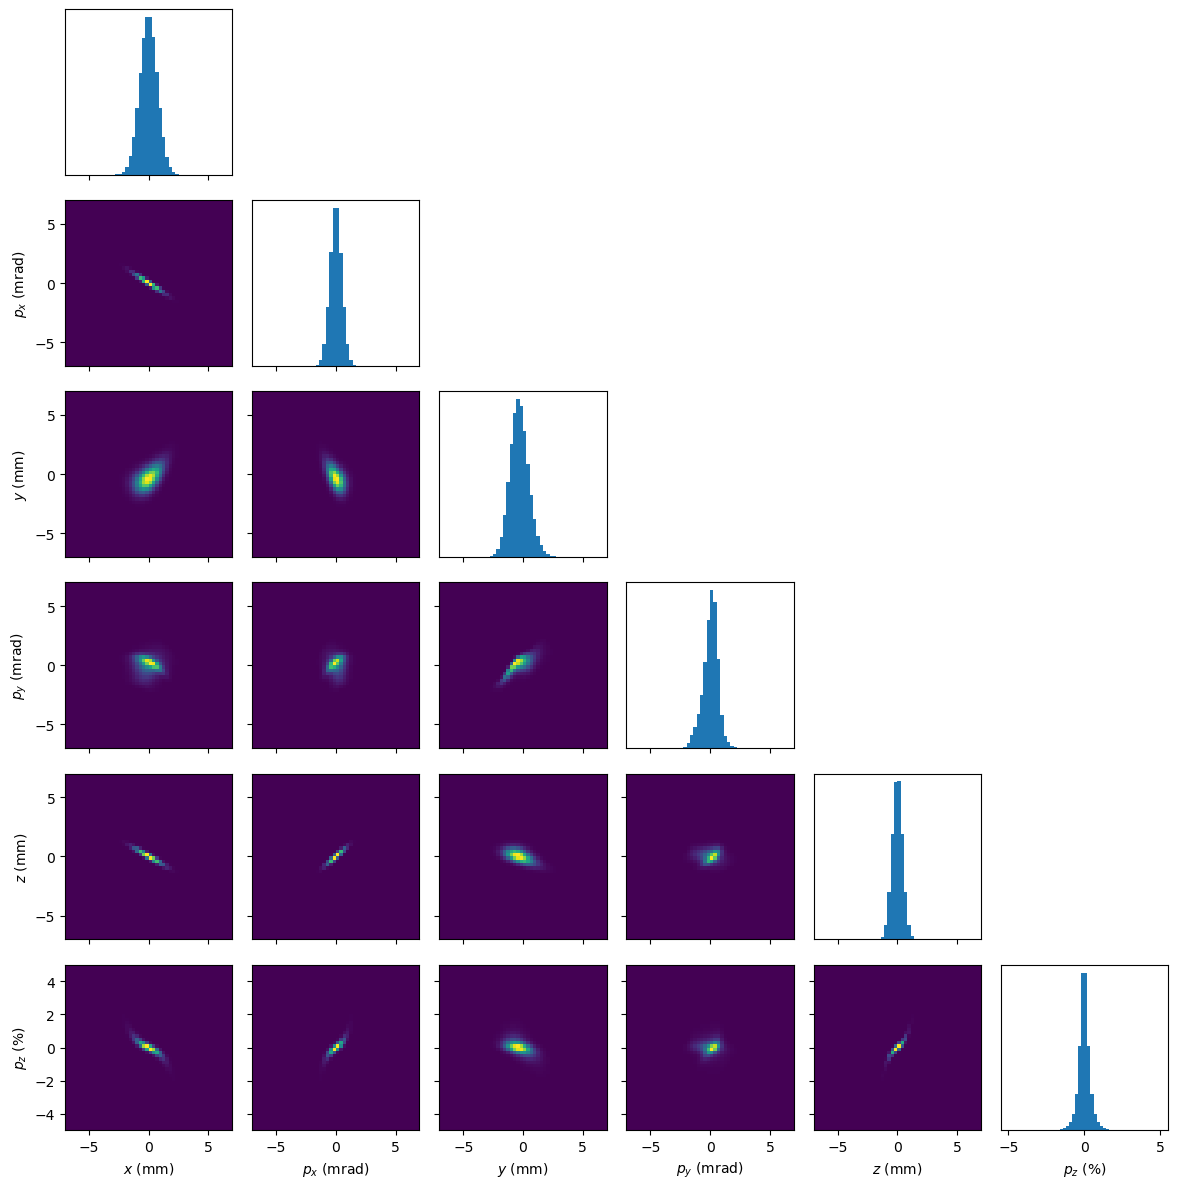

In [3]:
#plot gt beam
lims = np.array([[-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-7e-3, 7e-3],
                 [-5e-2, 5e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
#k1 =     8.75034
#k2 =  -24.402993
#k3 =   25.628154

k1 =             -2.942433
k2 =              9.613497
k3 =            -13.320705

#k1 =             -3.861105
#k2 =            -11.736413
#k3 =               6.68433

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-5, 5, n_ks) # quad ks
vs = torch.tensor([0, 3e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_awa_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/non_gaussian_beam/normal/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


torch.Size([200, 200])


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


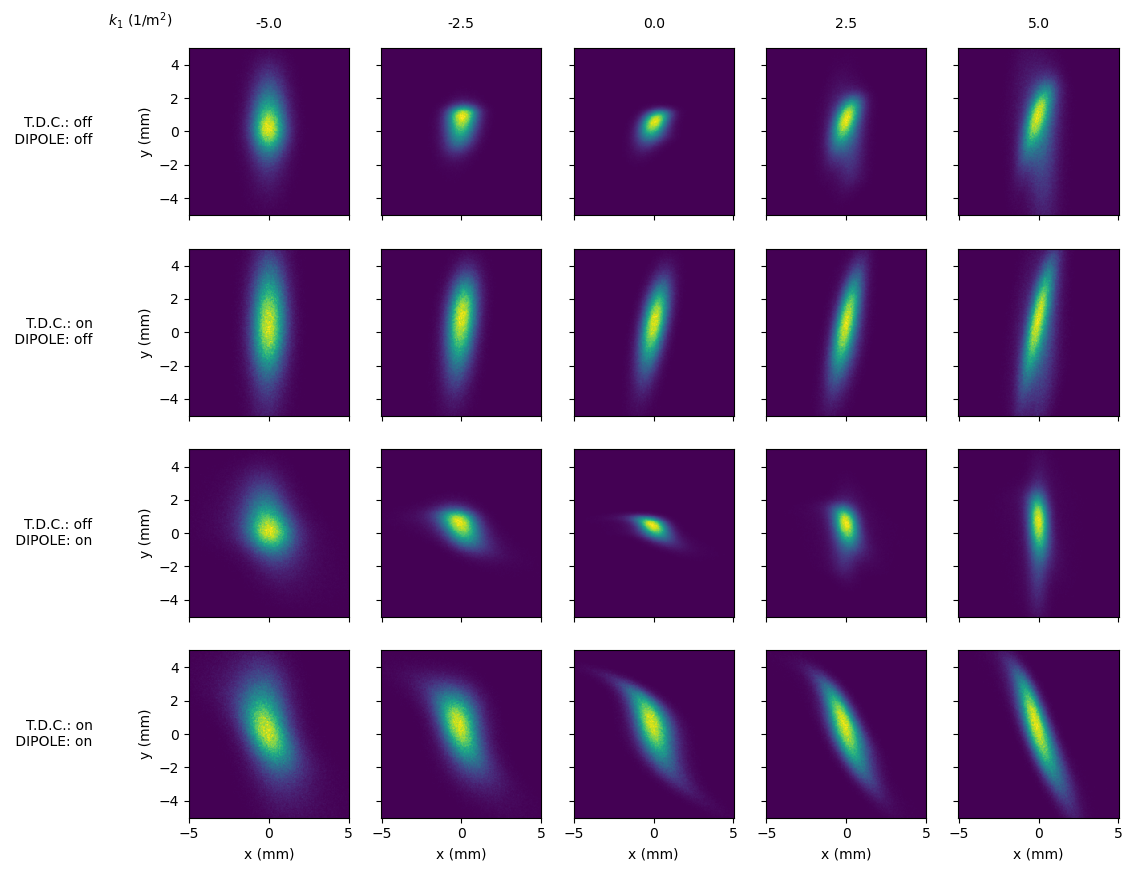

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan, bins)
fig.savefig("nonlinear_data.svg")

### 10,000 particles, multi-GPU

In [9]:
%%time

# training with 4 gpus
pred_beam_3d_scan_10_000, model = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    save_dir = save_dir,
    distribution_dump_frequency=500,
    distribution_dump_n_particles=1_000_000,
    )

Using device: cuda:0
0 tensor(3.6138e-05, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(4.4575e-06, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(4.3214e-06, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(3.9107e-06, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(3.9843e-06, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(3.6594e-06, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(3.9049e-06, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(3.5697e-06, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(3.7064e-06, device='cuda:0', grad_fn=<MeanBackward0>)
900 tensor(4.0692e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(3.8762e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1100 tensor(4.2005e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(3.6970e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1300 tensor(3.6067e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(3.8083e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1

In [ ]:
torch.cuda.empty_cache()

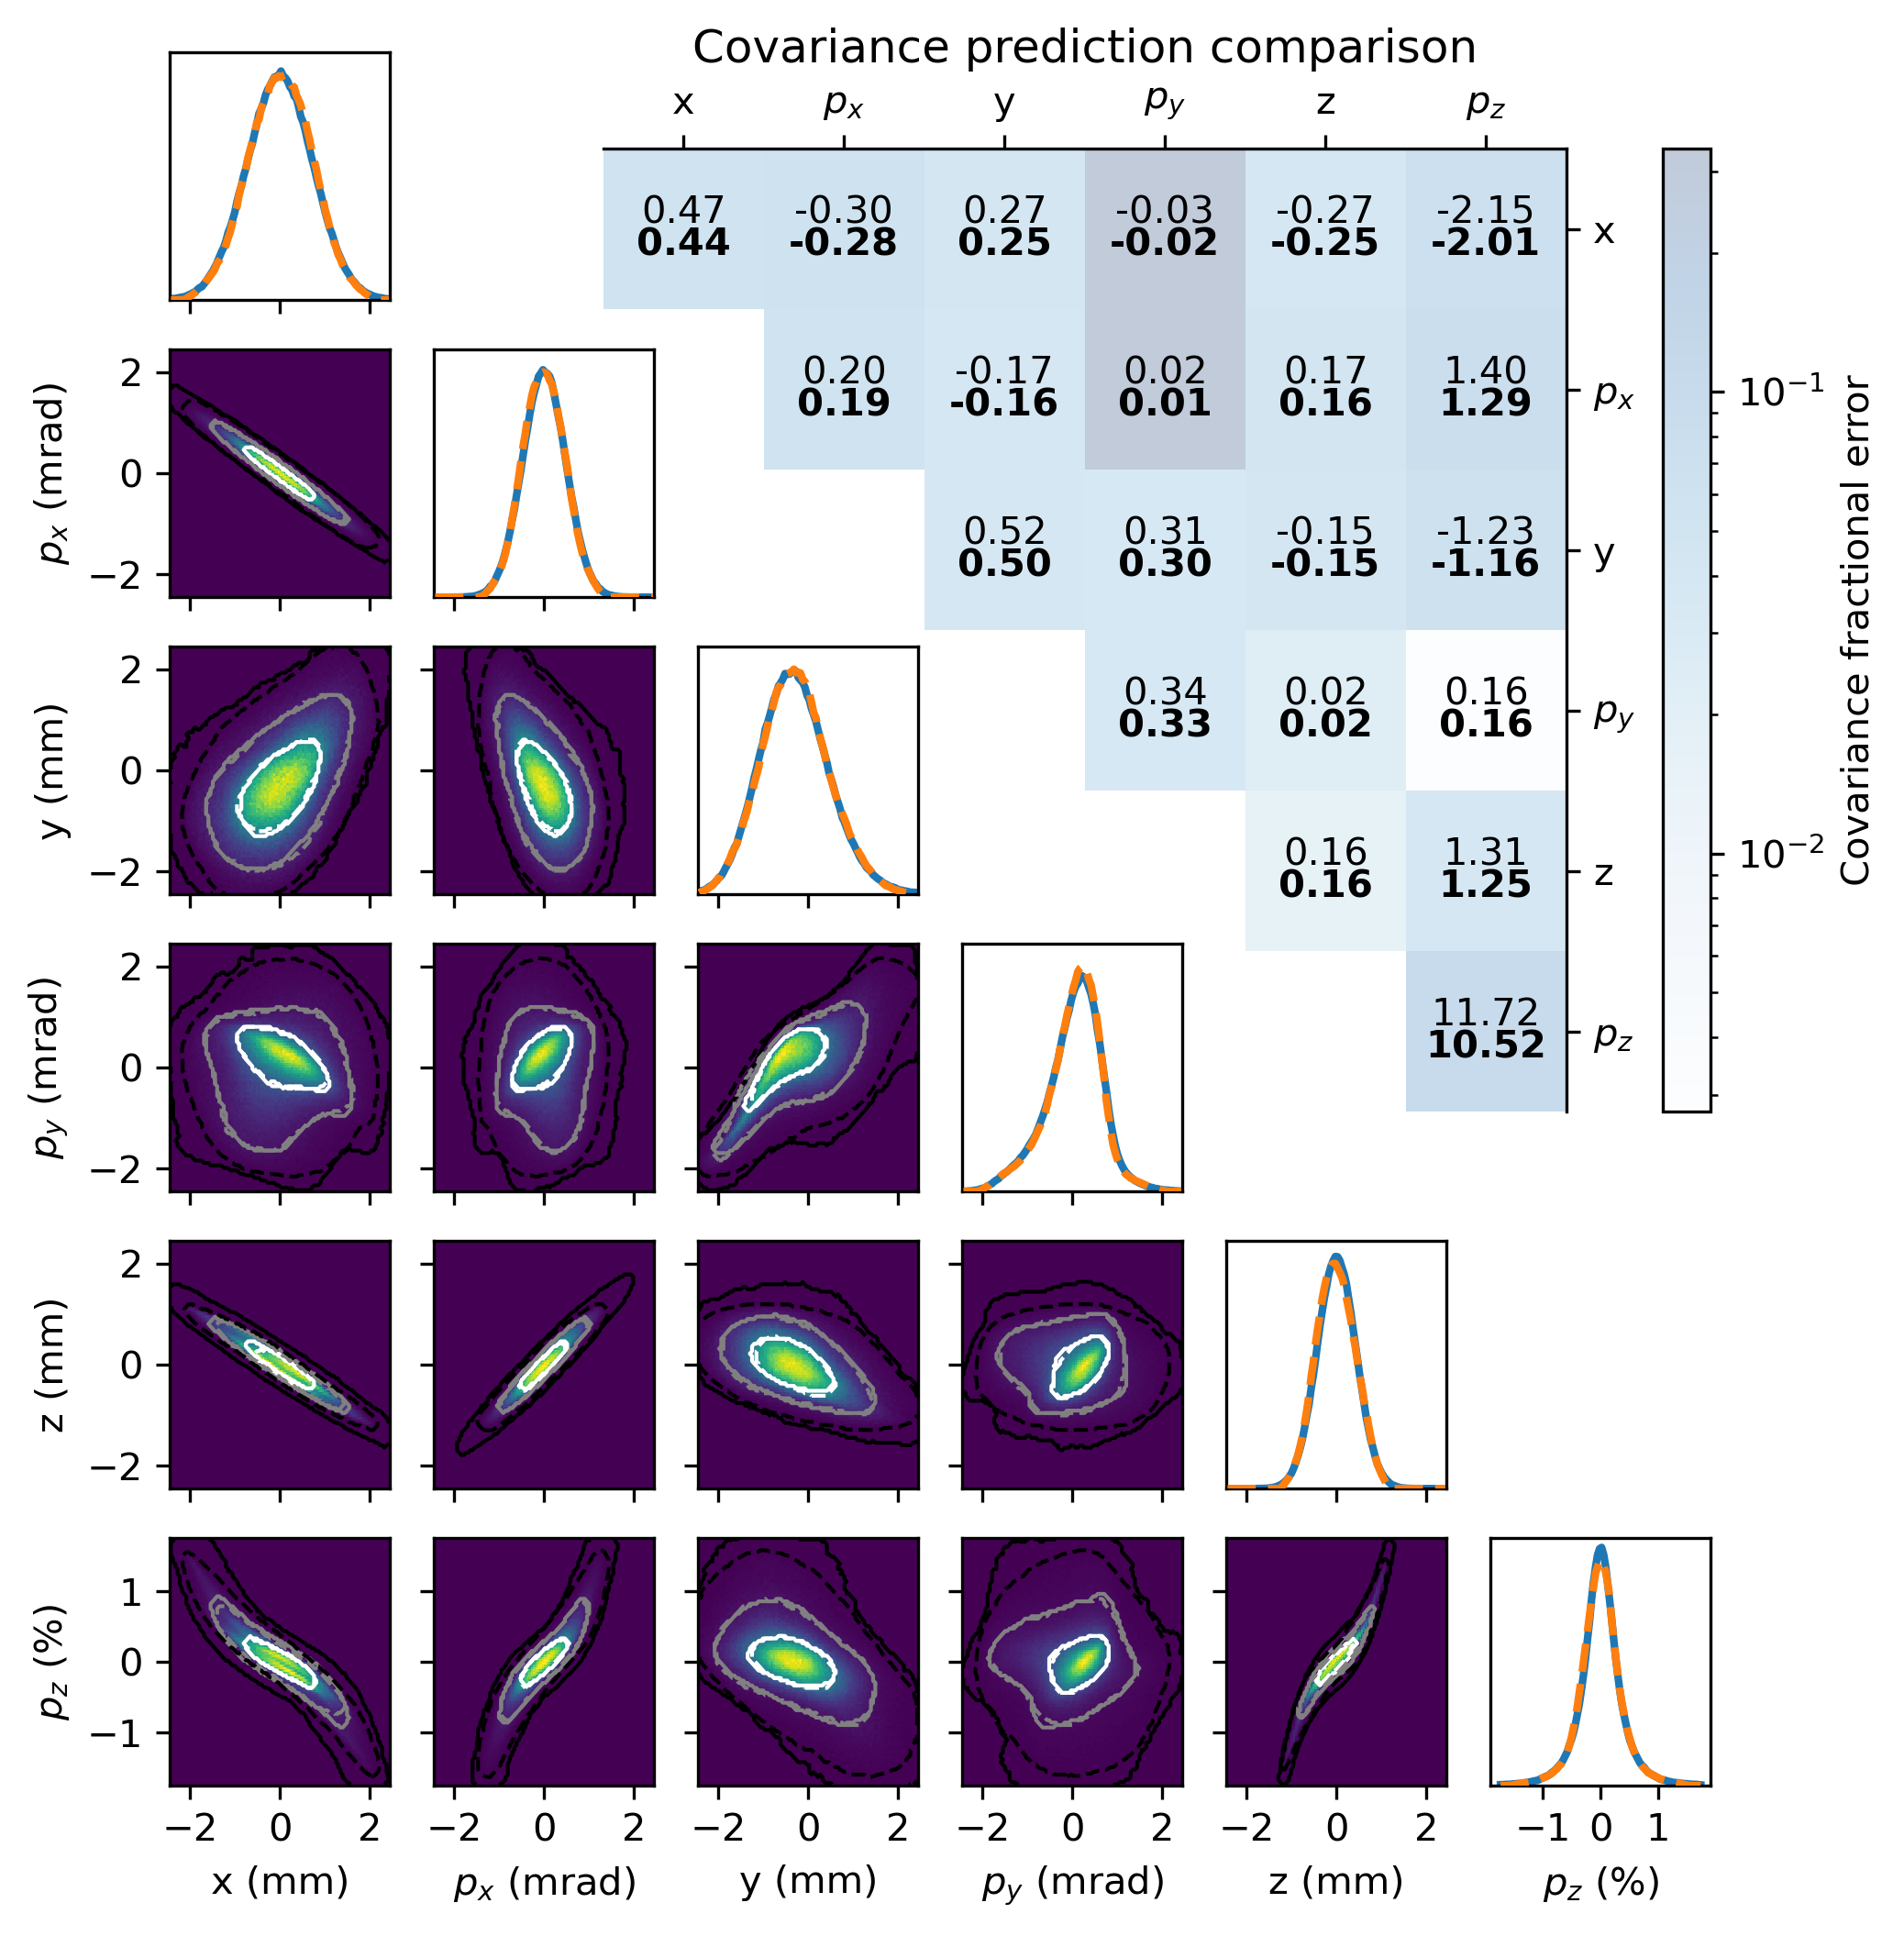

In [4]:
import torch
from stats import plot_prab_figure
import os

lims = np.array([[-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-7, 7],
                 [-5, 5]])*0.35

fig = plot_prab_figure(
    torch.load(os.path.join(save_dir, 'dist_3000.pt')),
    gt_beam,
    n_bins=100,
    contour_percentiles = [50, 90, 100],
    custom_lims=lims,
)
fig.savefig("nonlinear_reconstruction.png",dpi=300)
#fig.savefig("nonlinear_reconstruction.svg",dpi=300)

Text(0, 0.5, 'Y')

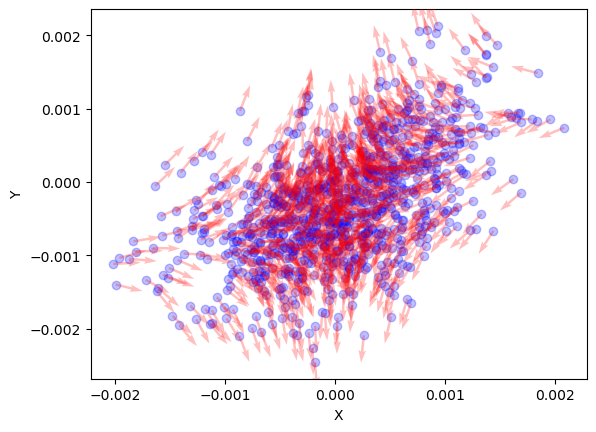

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Number of particles
num_particles = 10
import torch
import os
dist = torch.load(os.path.join(save_dir, 'dist_3000.pt')).data.numpy()

# Generate random positions and velocities
positions = dist[:1000,::2]  # Positions in the range [0, 10)
velocities = dist[:1000,1::2]*0.05

# Create a 3D plot
fig = plt.figure()

ax = fig.add_subplot(111)

# Plot the particles
ax.scatter(positions[:, 0], positions[:, 1], color='blue', marker='o',alpha=0.25)

# Plot the velocities as arrows
for i in range(len(positions)):
    ax.quiver(positions[i, 0], positions[i, 1],
              velocities[i, 0], velocities[i, 1],
              color='red',alpha=0.25,zorder=10, width=0.005)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

(10000,)


Text(0.5, 0.5, 'Y')

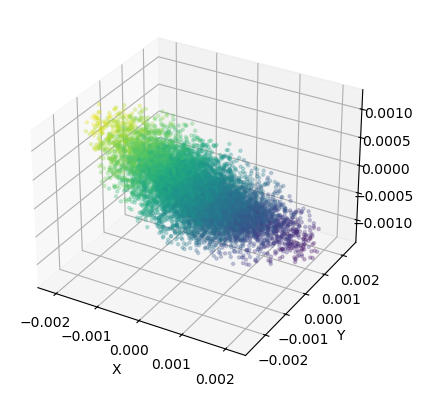

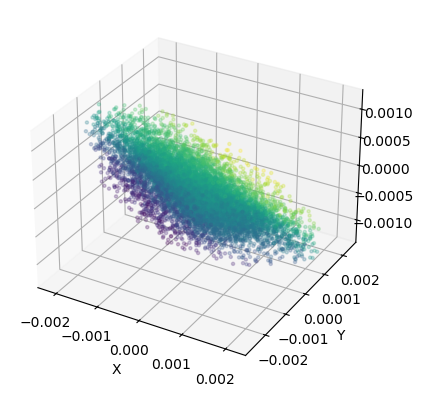

In [54]:
# Generate random positions and velocities
positions = dist[:10000,::2]  # Positions in the range [0, 10)
velocities = dist[:10000,1::2]*0.05
tv = np.linalg.norm(velocities[:,:2],axis=-1)
print(tv.shape)
# Create a 3D plot
fig = plt.figure()

ax = fig.add_subplot(111,projection="3d")

# Plot the particles
ax.scatter(positions[:, 0], positions[:, 1],positions[:, 2], c=velocities[:,0], marker=".",alpha=0.25)

# Plot the velocities as arrows
#for i in range(len(positions)):
#    ax.quiver(positions[i, 0], positions[i, 1],
#              velocities[i, 0], velocities[i, 1],
#              color='red',alpha=0.25,zorder=10, width=0.005)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

fig = plt.figure()

ax = fig.add_subplot(111,projection="3d")

# Plot the particles
ax.scatter(positions[:, 0], positions[:, 1],positions[:, 2], c=velocities[:,1], marker=".",alpha=0.25)

# Plot the velocities as arrows
#for i in range(len(positions)):
#    ax.quiver(positions[i, 0], positions[i, 1],
#              velocities[i, 0], velocities[i, 1],
#              color='red',alpha=0.25,zorder=10, width=0.005)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')